# Wrapping up Linear Models
> Part 5 of the mangoes_blog project

- branch: master
- toc: true 
- badges: false
- comments: false
- sticky_rank: 5
- author: Huon Fraser
- categories: [mangoes]

In [1]:
#collapse-hide
import pathlib
import pandas as pd
import numpy as np

import sys
sys.path.append('/notebooks/Mangoes/src/')
model_path  = '../models/'

from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from codetiming import Timer
from sklearn.model_selection import GroupKFold
from scikit_models import *
from skopt.space import Real, Integer
from lwr import LocalWeightedRegression
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
#collapse-hide
mangoes=load_mangoes()

train_data,test_data = train_test_split(mangoes)
train_X, train_y, train_cat = X_y_cat(train_data,min_X=684,max_X=990)
test_X, test_y, test_cat = X_y_cat(test_data,min_X=684,max_X=990)
nrow,ncol=train_X.shape
groups = train_cat['Pop']
splitter=GroupKFold()

## Ensemble methods

We now compare our approach to off the shelf ensemble models that are typically the state of the art for tabular problems. We train off-the-shelf variants of [Random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html), the default sklearn [Gradient boosting regression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) and [XGBoost](https://xgboost.readthedocs.io/en/stable/). A caveat here is that each of these models could probably be optimised further. Intitial performance was dissapointing so we used PLS preprocessing for these experiemnts.


### Random Forest

100%|██████████| 50/50 [1:50:05<00:00, 243.11s/it]

Best model had an MSE of 1.4690
Setting parameters as: {'scaler__n_components': 10}
Elapsed time: 6632.9616 seconds


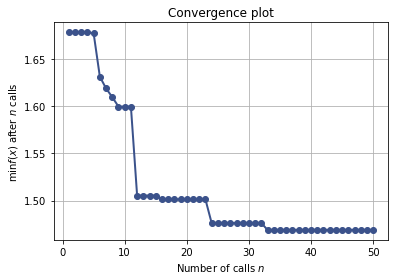

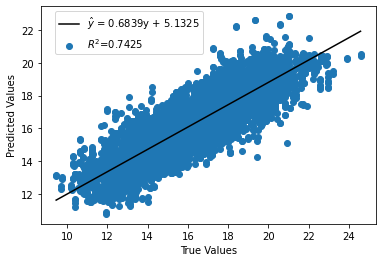

In [3]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline([
    ('scaler', PLSRegression()),
    ('model',RandomForestRegressor())
    ])

space  = [Integer(2,ncol,name='scaler__n_components'),
         ]

opt = Optimiser(space,model,train_X,train_y,splitter=splitter,groups=groups)
model_forest,result_forest = opt.optimise(save_file=model_path+'5_random_forest')

### Scikit-learn Gradient Boosting



100%|██████████| 50/50 [54:29<00:00, 60.69s/it]

Best model had an MSE of 1.2088
Setting parameters as: {'scaler__n_components': 28}
Elapsed time: 3305.1457 seconds


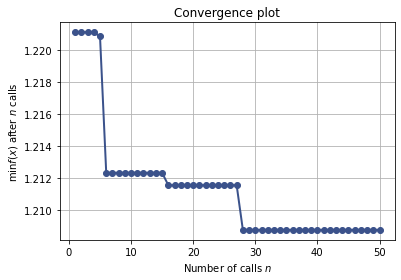

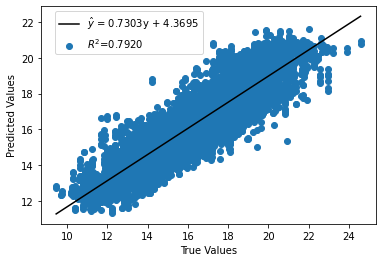

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

model = Pipeline([
    ('scaler', PLSRegression()),
    ('model',GradientBoostingRegressor(random_state=0))
    ])


space  = [Integer(2,ncol,name='scaler__n_components'),
         ]

opt = Optimiser(space,model,train_X,train_y,splitter=splitter,groups=groups)
model_boost,result_boost = opt.optimise(save_file=model_path+'5_gradboost')


### XGBoost



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:09<07:38,  9.35s/it]

  4%|▍         | 2/50 [00:21<08:37, 10.78s/it]

  6%|▌         | 3/50 [00:32<08:45, 11.18s/it]

  8%|▊         | 4/50 [00:44<08:37, 11.24s/it]

 10%|█         | 5/50 [00:53<07:47, 10.39s/it]

 12%|█▏        | 6/50 [00:59<06:38,  9.06s/it]

 14%|█▍        | 7/50 [01:04<05:36,  7.81s/it]

 16%|█▌        | 8/50 [01:07<04:15,  6.09s/it]

 18%|█▊        | 9/50 [01:11<03:53,  5.71s/it]

 20%|██        | 10/50 [01:19<04:11,  6.29s/it]

 22%|██▏       | 11/50 [01:33<05:35,  8.61s/it]

 24%|██▍       | 12/50 [01:39<04:53,  7.73s/it]

 26%|██▌       | 13/50 [01:49<05:13,  8.48s/it]

 28%|██▊       | 14/50 [01:54<04:31,  7.54s/it]

 30%|███       | 15/50 [01:59<03:53,  6.66s/it]

 32%|███▏      | 16/50 [02:04<03:31,  6.21s/it]

 34%|███▍      | 17/50 [02:12<03:42,  6.75s/it]

 36%|███▌      | 18/50 [02:17<03:17,  6.18s/it]

 38%|███▊      | 19/50 [02:22<03:00,  5.81s/it]

 40%|████      | 20/50 [02:26<02:41,

Best model had an MSE of 1.2314
Setting parameters as: {'scaler__n_components': 22}
Elapsed time: 339.8149 seconds


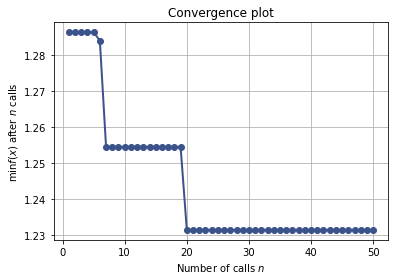

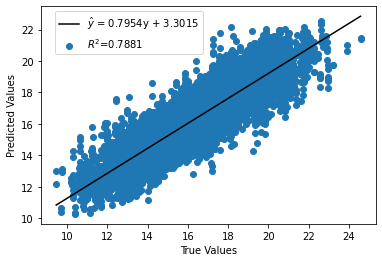

In [6]:
import xgboost as xgb
model = Pipeline([
    ('scaler', PLSRegression()),
    ('model',xgb.XGBRegressor(tree_method="gpu_hist"))
    ])
space = [
        Integer(2,ncol,name='scaler__n_components')
        ]

opt = Optimiser(space,model,train_X,train_y,splitter=splitter,groups=groups)
model_xg, result_xg = opt.optimise(save_file=model_path+'5_xgboost')

### Ensembles of  PLS-LWR

We've left them until last because typically emsembles will always give better performance; any of the models looked at in the previous 3 parts could be ensmbled. We take our previous best model (SG-PLS-LWR) and build a [bagging regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) ensemble. This builds 10 copys of a model, with each trained on a sample (with replacement) of the dataset. Predictions are then made by taking the mean of the ensemble.

Results are no better than for the non-ensembled version. A possible explanation is that bagging reduces the density of the feature space, interfering with the locally weighted regressions.

In [8]:
from sklearn.ensemble import BaggingRegressor
from joblib import dump, load

pipe =  load(model_path+'4_pp-pls-lwr_model.joblib') 
model = BaggingRegressor(pipe)

mse = cross_validate(model,train_X,train_y,splitter=splitter,groups=groups,plot=True)
print(f'Train set MSE: {mse}')

FileNotFoundError: [Errno 2] No such file or directory: '../models/4_pp-pls-lwr_model.joblib'

In [ ]:
model, mse_test = evaluate(model,train_X,train_y,test_X,test_y,plot=True)

## Comparing Techniques


So far in this series, we started with a multiple linear regression (LR) and dded complexity; feature extraction with partial least squares (PLS), lazy instance weights with locally weighted regressions (LWR) and preprocessing with Savitsky Golay (SG). Adding ach of these components incrementally improved performance during cross-validation, although the hyperparameter settings were not always consistent. The final model in this series (SG-PLS-LWR) gave a cross-validation MSE of 0.7223 and a test MSE of 0.7686.

When we compared this model to off-the-shelf ensembles (including XGBoost) and a bagging-ensemble extension, we found that these underperformed our model. To round out this part of the series we compare our results to the original Mangoes results achieved by Anderson et al. 

In the table we below we compare two models by Anderson et al, LPLS, their best performing locally weighted PLS model, and Ensemble, their best ensemble based model to the models we have built in this series. Our approach gave substantially better results that both models.  Without going into too much detail, this is likely due to the Anderson et al. models fixing the number of components for PLS to a relatively low number, whereas we kept this hyperparmater flexible.

| Model         | CV Score        | Test Score  |
| ------------  | :-------------: | -----:      |
| LR            | 0.8157          | 1.1147 |
| PLS-LR        | 0.8116          | -------  |
| LWR           | 0.7868          | -------|
| PLS-LWR       | 0.7520          | 0.8113  |
| SG-PLS-LWR    | 0.7223          | 0.7686 |
| E(SG-PLS-LWR) | 0.7236          | 0.7801   |
| Anderson et al. LPLS   | 0.66   | 0.887   |
| Anderson et al. Ensemble | 0.56 | 0.850  |
